<a href="https://colab.research.google.com/github/Yutthana-BJ/Project_YB/blob/main/Customer%20Segmentation%3A%20K-means%20Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Segmentation Analysis Using K-means Clustering**

---



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer

# 1. Input Data
Download the data set from https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis Then that, save the downloaded data in `Google Drive`.

In [75]:
from google.colab import drive
drive.mount('/content/drive')
data_set = '/content/drive/MyDrive/Colab Notebooks/DataSet/marketing_campaign.csv'
df = pd.read_csv(data_set)
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


# 2. Data Preparation
Validate, clean, and transform the dataset into the desired format, ensuring it is ready for analysis.

In [76]:
# Check for missing values in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [77]:
# Remove rows with missing values in the "Income" column from the dataset
df = df.dropna(subset=['Income'])
print("The total number of sample after removing rows with missing values are:", len(df))

The total number of sample after removing rows with missing values are: 2216


In [78]:
# Convert the "Dt_Customer" column to a datetime data type
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)

# Rename columns in a dataset for better readability and usability
df = df.rename(columns={"MntWines":"Wines", "MntFruits":"Fruits", "MntMeatProducts":"Meat", "MntFishProducts":"Fish", "MntSweetProducts":"Sweets", "MntGoldProds":"Gold"})

# Feature Engineering
df['Age'] = 2024 - df['Year_Birth']
df['Childrenhome'] = df['Kidhome'] + df['Teenhome']
df['Days_Since_Signup'] = (pd.Timestamp.today() - df['Dt_Customer']).dt.days
df['Spent'] = df['Wines'] + df['Fruits'] + df['Meat'] + df['Fish'] + df['Sweets'] + df['Gold']
df['Total_Promotions'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']

# Remove unwanted columns from the data
df = df.drop(columns=['ID', 'Year_Birth', "Dt_Customer", 'Z_CostContact', 'Z_Revenue'], axis=1)

<ipython-input-78-f47ebd6873d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)


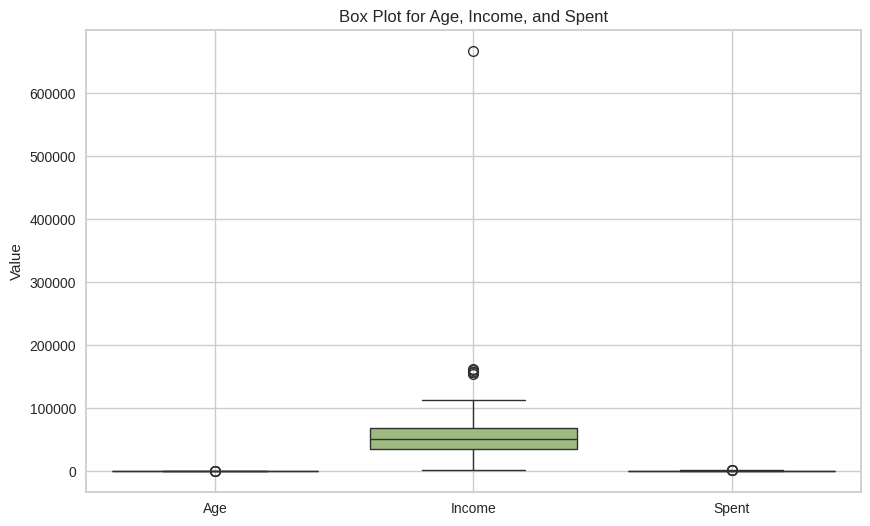

In [79]:
# Create box plots for the variables Age, Income, and Spent to visualize their distribution and identify outliers
metric = ['Age', 'Income', 'Spent']
plt.figure(figsize=(10, 6))
sns.boxplot(data = df[metric])
plt.title('Box Plot for Age, Income, and Spent')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [80]:
# Remove outliers in the variables Age, Income, and Spent from the dataset
bounds = {}
for i in metric:
    Q1 = np.percentile(df[i], 25)
    Q3 = np.percentile(df[i], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    bounds[i] = (lower_bound, upper_bound)

for i in metric:
    lower_bound, upper_bound = bounds[i]
    df = df[(df[i] >= lower_bound) & (df[i] <= upper_bound)]

print("The total number of samples after removing the outliers are:", len(df))

The total number of samples after removing the outliers are: 2202


In [81]:
# Transform or replace the education level values in the "Education" column by categorizing the education levels into 3 groups: Basic, Graduation, and Postgraduate
def education_level(level):
    if level in ["Basic"]:
        return "Basic"
    elif level in ["Graduation"]:
        return "Graduate"
    elif level in [ "Master", "2n Cycle", "PhD"]:
        return "Postgraduate"
    else:
        return "Unknown"
df['Education'] = df['Education'].apply(education_level)
df['Education'].value_counts()

Education
Graduate        1112
Postgraduate    1036
Basic             54
Name: count, dtype: int64

In [82]:
# Transform or replace the status values in the "Marital_Status" column by categorizing the status into 5 groups: Married, Together, Single, Divorced, and Other
def marital_status(status):
    if status in ["Married"]:
        return "Married"
    elif status in ["Together"]:
        return "Together"
    elif status in ["Single", "Alone"]:
        return "Single"
    elif status in ["Divorced", "Widow"]:
        return "Divorced"
    else:
        return "Other"
df['Marital_Status'] = df['Marital_Status'].apply(marital_status)
df['Marital_Status'].value_counts()

Marital_Status
Married     854
Together    567
Single      471
Divorced    306
Other         4
Name: count, dtype: int64

In [89]:
# Create dummy variables or perform One-Hot Encoding on the "Education" and "Marital_Status" columns
Encoder_df = pd.get_dummies(df,columns=['Education', 'Marital_Status'], prefix=['Education', 'Marital_Status'])
for col in Encoder_df.columns:
    if Encoder_df[col].dtype == bool:
        Encoder_df[col] = Encoder_df[col].astype(int)
Encoder_df.reset_index(drop=True, inplace=True)
Encoder_df

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,Total_Promotions,Cluster,Education_Basic,Education_Graduate,Education_Postgraduate,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Other,Marital_Status_Single,Marital_Status_Together
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,1,0,0,0,0,1,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,1,0,1,0,0,0,0,1,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,0,0,0,1,0,0,0,0,0,1
3,26646.0,1,0,26,11,4,20,10,3,5,...,0,1,0,1,0,0,0,0,0,1
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,2,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,61223.0,0,1,46,709,43,182,42,118,247,...,0,3,0,1,0,0,1,0,0,0
2198,64014.0,2,1,56,406,0,30,0,0,8,...,1,3,0,0,1,0,0,0,0,1
2199,56981.0,0,0,91,908,48,217,32,12,24,...,1,0,0,1,0,1,0,0,0,0
2200,69245.0,0,1,8,428,30,214,80,30,61,...,0,3,0,0,1,0,0,0,0,1


# 3. Dimensionality Reduction
Use `Principal Component Analysis (PCA)` to comprehensively examine the data structure and identify underlying relationships. Focus on the Principal Components that hold the greatest relevance to the dataset.

In [52]:
# Identify the columns required for clustering and standardize the selected data
Feature = Encoder_df.drop(columns=['Kidhome', 'Teenhome', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Total_Promotions','Complain', 'Response'], axis=1)
Feature_scaler = pd.DataFrame(StandardScaler().fit_transform(Feature), columns=Feature.columns)

Explained variance ratio of PC1, PC2, PC3: [0.28857213 0.08450852 0.07682147]


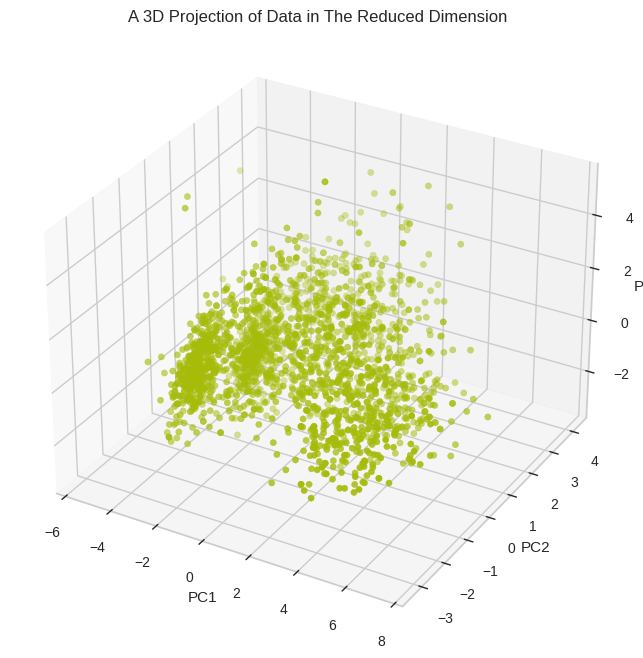

In [53]:
# Principal Component Analysis (PCA) for Data Dimensionality Reduction to 3 Dimensions
pca = PCA(n_components=3)
Feature_PCA = pd.DataFrame(pca.fit_transform(Feature_scaler), columns=['PC1', 'PC2', 'PC3'])
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio of PC1, PC2, PC3:", explained_variance_ratio)

# Create a 3D scatter plot to visualize the distribution of data after dimensionality reduction
x = Feature_PCA['PC1']
y = Feature_PCA['PC2']
z = Feature_PCA['PC3']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z, c="#A6BC09", marker="o")
ax.set_title("A 3D Projection of Data in The Reduced Dimension")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

PC1 explains 27.98% of the data variance, capturing the most significant patterns in the data. PC2 and PC3 explain 8.82% and 7.25% of the data variance, respectively. Together, these `3 principal components explain 44.05%` of the total data variance.

# 4. Clustering
Customer segmentation using the `K-Means clustering algorithm` based on principal component analysis (PCA) results

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

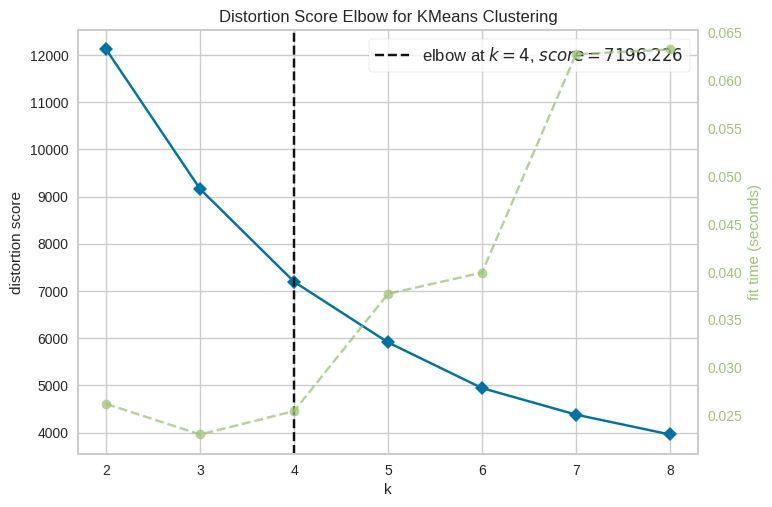

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [54]:
# Determining the optimal number of clusters for data partitioning using the K-Means clustering algorithm
Elbow_M = KElbowVisualizer(KMeans(), k=8)
Elbow_M.fit(Feature_PCA)
Elbow_M.show()

After k = 4, the decrease in distortion score is not as significant as before, indicating that `k = 4 is the optimal number of clusters`.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


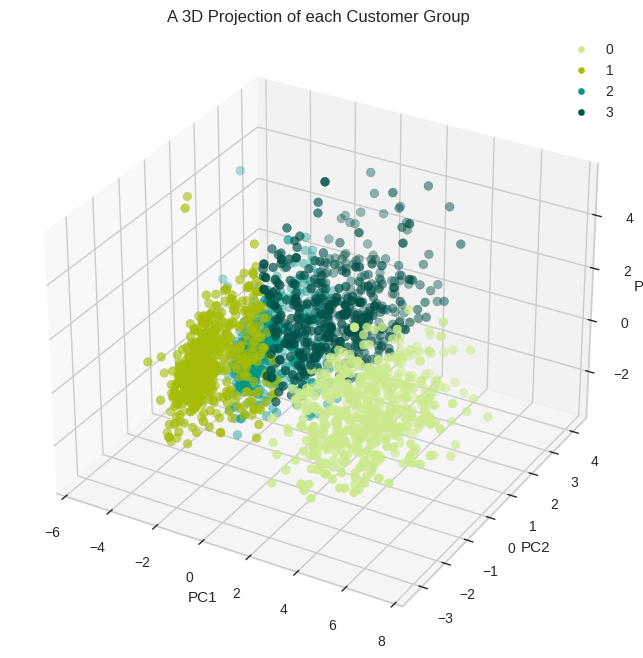

In [55]:
# Partition the data into 4 clusters using the K-Means clustering algorithm
cluster_label = KMeans(n_clusters=4, random_state=44).fit_predict(Feature_PCA)
Feature_PCA['Cluster'] = cluster_label

# Create a 3D chart showing the distribution of each customer group
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d')
colors = ['#CCEA8D', '#A6BC09', '#019587', '#005148']
scatter_colors = [colors[cluster] for cluster in Feature_PCA['Cluster']]
ax.scatter(x, y, z, s=40, c=scatter_colors, marker='o')
ax.set_title("A 3D Projection of each Customer Group")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

legend_labels = ['0', '1', '2', '3']
for i, legend_color in enumerate(colors):
    ax.scatter([], [], [], c=legend_color, label=legend_labels[i])
ax.legend()
plt.show()

# 5. Customer Profiling and Analysis
Analyze `customer's information and behavioral` patterns to identify commonalities among customer segments and differentiate between them in order to create customer profiles for each segment.

In [84]:
# Add a "Cluster" column to the dataset, which stores the cluster_label values obtained from clustering the data
df['Cluster'] = cluster_label
df['Cluster'] = df['Cluster'].astype('category')
df.reset_index(drop=True, inplace=True)
df

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Childrenhome,Days_Since_Signup,Spent,Total_Promotions,Cluster
0,Graduate,Single,58138.0,0,0,58,635,88,546,172,...,0,0,0,1,67,0,4311,1617,0,0
1,Graduate,Single,46344.0,1,1,38,11,1,6,2,...,0,0,0,0,70,2,3761,27,0,1
2,Graduate,Together,71613.0,0,0,26,426,49,127,111,...,0,0,0,0,59,0,3960,776,0,0
3,Graduate,Together,26646.0,1,0,26,11,4,20,10,...,0,0,0,0,40,1,3787,53,0,1
4,Postgraduate,Married,58293.0,1,0,94,173,43,118,46,...,0,0,0,0,43,1,3809,422,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,Graduate,Married,61223.0,0,1,46,709,43,182,42,...,0,0,0,0,57,1,4029,1341,0,3
2198,Postgraduate,Together,64014.0,2,1,56,406,0,30,0,...,1,0,0,0,78,3,3667,444,1,3
2199,Graduate,Divorced,56981.0,0,0,91,908,48,217,32,...,0,0,0,0,43,0,3803,1241,1,0
2200,Postgraduate,Together,69245.0,0,1,8,428,30,214,80,...,0,0,0,0,68,1,3804,843,0,3


<ipython-input-57-a0af64d7b5b6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=df['Cluster'], palette=palettes)


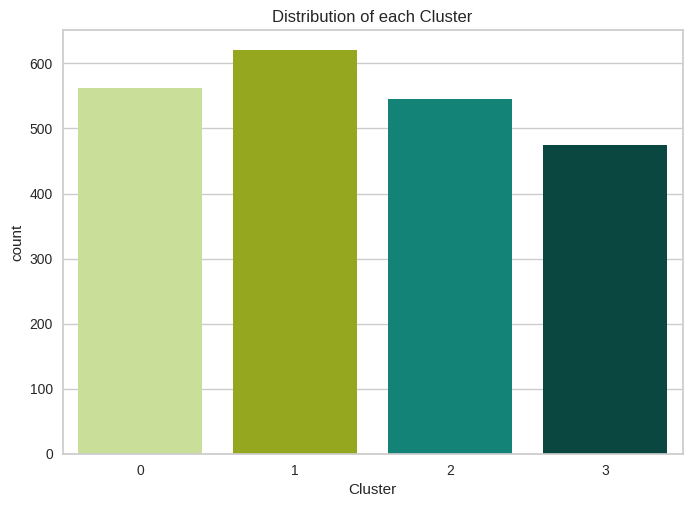

In [57]:
# Create a count plot to visualize the distribution of each cluster
palettes = {'0': colors[0], '1': colors[1], '2': colors[2], '3': colors[3]}
pl = sns.countplot(x=df['Cluster'], palette=palettes)
pl.set_title("Distribution of each Cluster")
plt.show()

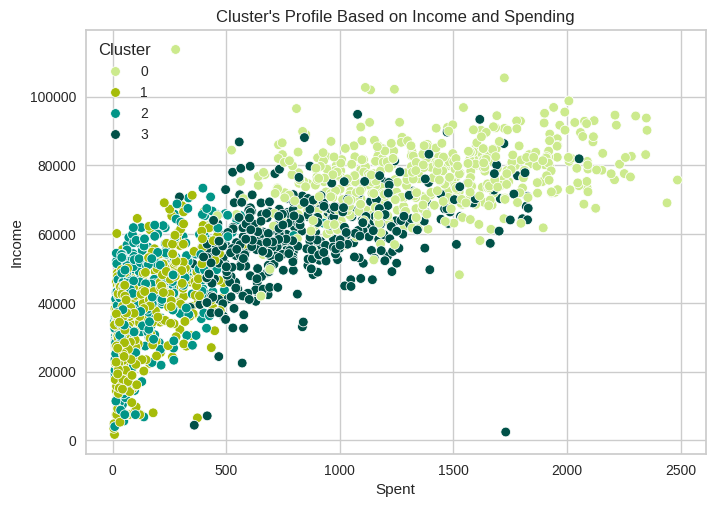

Income                                                         \
         count          mean           std      min      25%      50%   
Cluster                                                                 
0        562.0  76114.784698   9281.581149  42000.0  70133.5  76081.0   
1        620.0  34352.003226  12990.368500   1730.0  24588.0  34026.0   
2        545.0  39134.205505  13004.139550   4023.0  30899.0  38452.0   
3        475.0  59273.412632  11400.200398   2447.0  53186.5  59821.0   

                            Spent                                          \
             75%       max  count         mean         std    min     25%   
Cluster                                                                     
0        82023.0  113734.0  562.0  1365.638790  411.677741  277.0  1045.5   
1        43180.0   71322.0  620.0   123.837097  118.232927    5.0    41.0   
2        47821.0   73395.0  545.0   142.510092  140.325372    8.0    44.0   
3        66168.0   94871.0  475.0   860.067368  344.367891  294.0   587.0   

                                  
            50%      75%     max  
Cluster                           
0        1337.0  1643.75  2486.0  
1          70.0   177.25   577.0  
2          78.0   209.00   928.0  
3         795.0  1069.00  2053.0

In [96]:
# Create a scatter plot to visualize the distribution or relationship between "Income" and "Spending" for each customer group
pal = {0: colors[0], 1: colors[1], 2: colors[2], 3: colors[3]}
pl = sns.scatterplot(data=df ,x=df['Spent'], y=df['Income'], hue=df['Cluster'], palette=pal)
pl.set_title("Cluster's Profile Based on Income and Spending")
plt.show()

# Summarize key statistics (e.g. average, maximum, minimum)
df.groupby('Cluster')[['Income', 'Spent']].describe()

*  Group 0 : high income & high spending
*  Group 1 : low income & low spending
*  Group 2 : low income & low spending
*  Group 3 : high income & average spending

---



<Figure size 800x550 with 0 Axes>

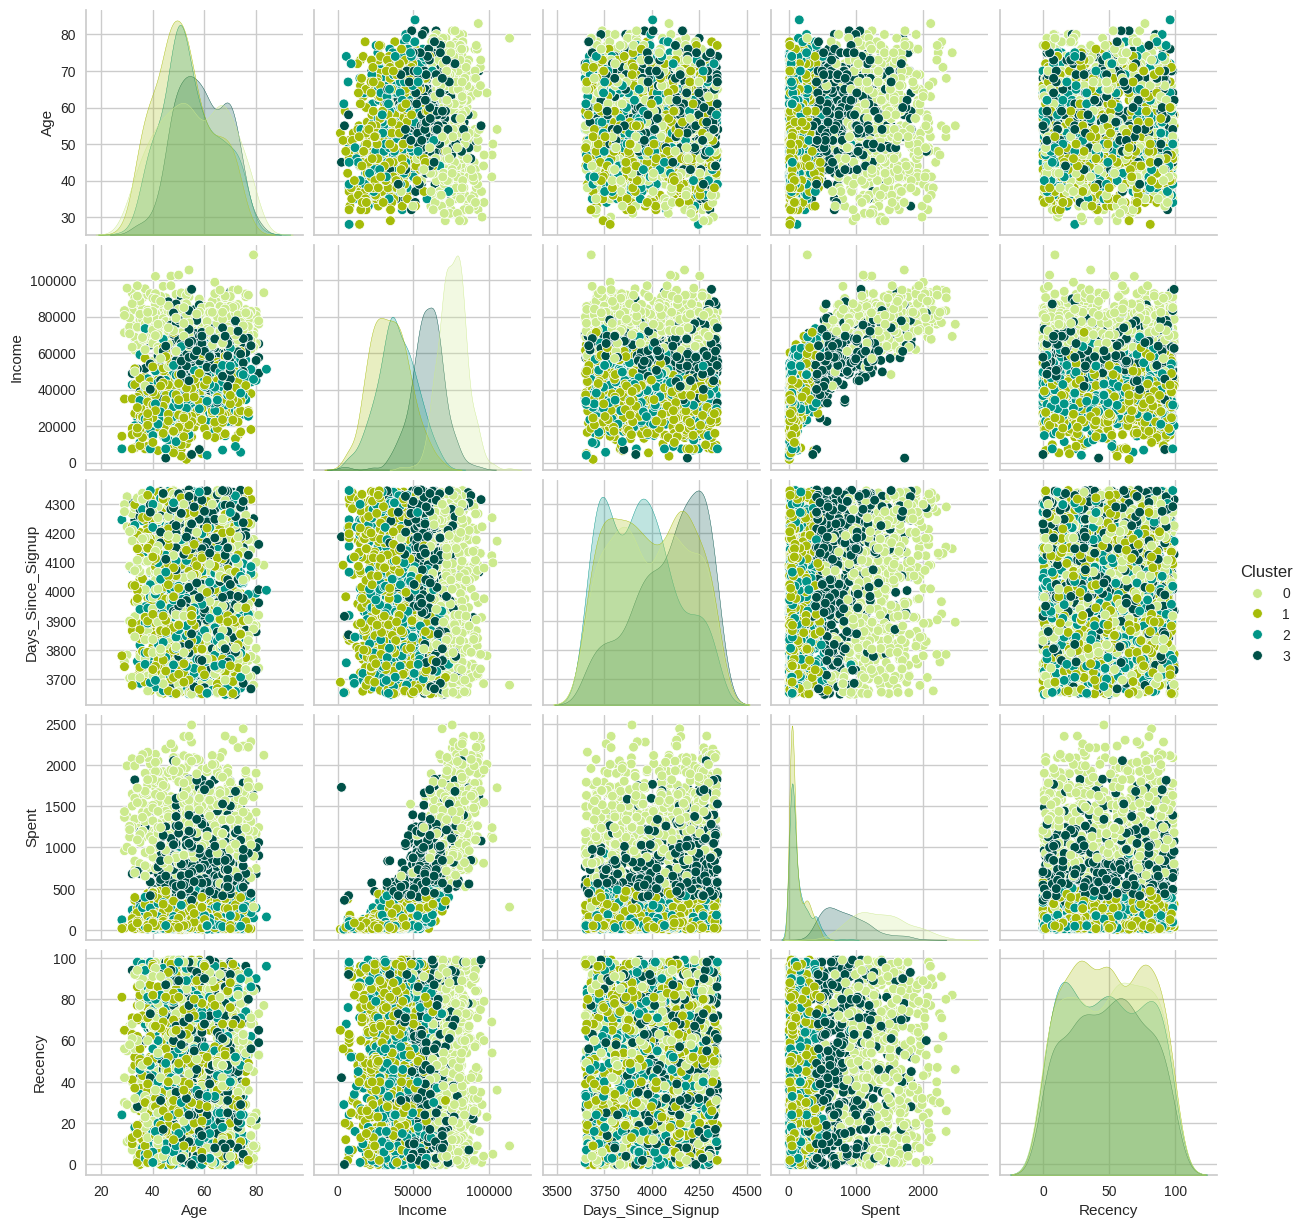

In [59]:
# Create a Pair plot graph to show the distribution or relationship of multiple variables for each customer group
To_Plot = ['Age', 'Income', 'Days_Since_Signup','Spent', 'Recency', 'Cluster']
plt.figure()
sns.pairplot(df[To_Plot], hue= 'Cluster', palette=pal)
plt.show()

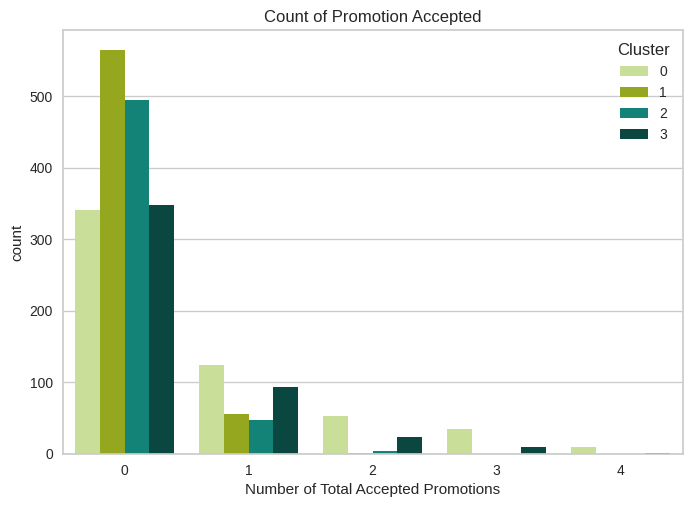

In [60]:
# Create a bar chart (countplot) to show the count of all promotion accepts for each customer group
plt.figure()
pl = sns.countplot(x=df['Total_Promotions'], hue=df['Cluster'], palette=pal)
pl.set_title("Count of Promotion Accepted")
pl.set_xlabel("Number of Total Accepted Promotions")
plt.show()

Overall, there was a lackluster response to all 5 campaigns, with very few customers participating. Moreover, no customer has yet completed all 5 campaigns. Customer group 0 has the highest campaign participation rate compared to other groups, followed by customer group 3.


<ipython-input-61-8c0109c9cb5c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(y=df[Purchase[i]], x=df['Cluster'], palette=palettes, ax=ax)
<ipython-input-61-8c0109c9cb5c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(y=df[Purchase[i]], x=df['Cluster'], palette=palettes, ax=ax)


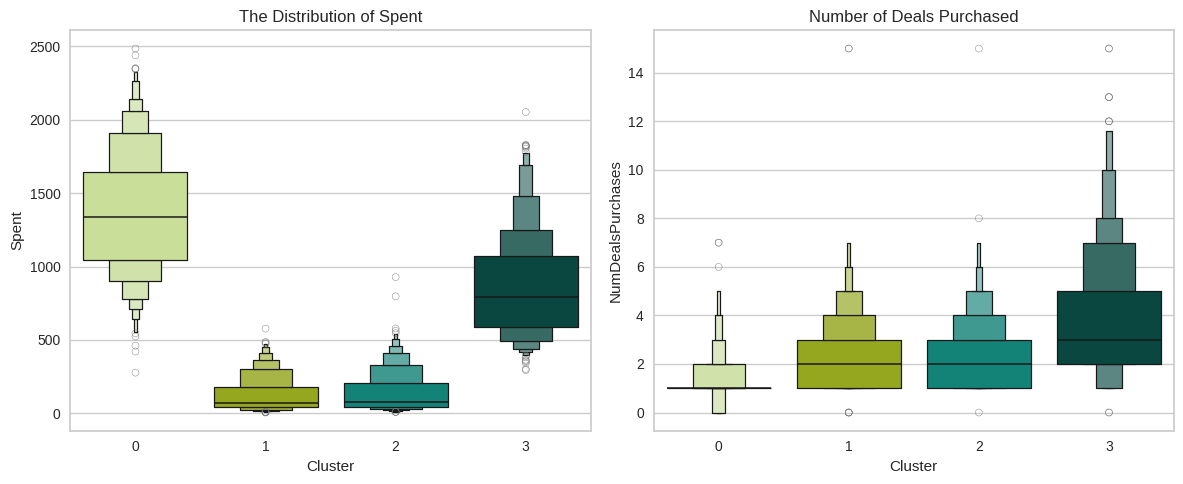

In [61]:
# Create a Boxen plot to visualize the distribution of Spent and Number of Deals Purchased across different clusters
Purchase = ['Spent', 'NumDealsPurchases']
Title = ['The Distribution of Spent', 'Number of Deals Purchased']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, ax in zip(range(len(Purchase)), axes):
    sns.boxenplot(y=df[Purchase[i]], x=df['Cluster'], palette=palettes, ax=ax)
    ax.set_title(Title[i])
plt.tight_layout()
plt.show()

`Spenting:` Group 0 customers have the highest spending in all categories, followed by Group 3. Both of these groups have significantly higher spending than the remaining two groups.

`Number of Deals Purchased:` Customer group 3 has the highest average number of purchases, in contrast to group 0 which has the lowest average number of purchases. However, group 0 customers are still the target group that generates the most sales.

---






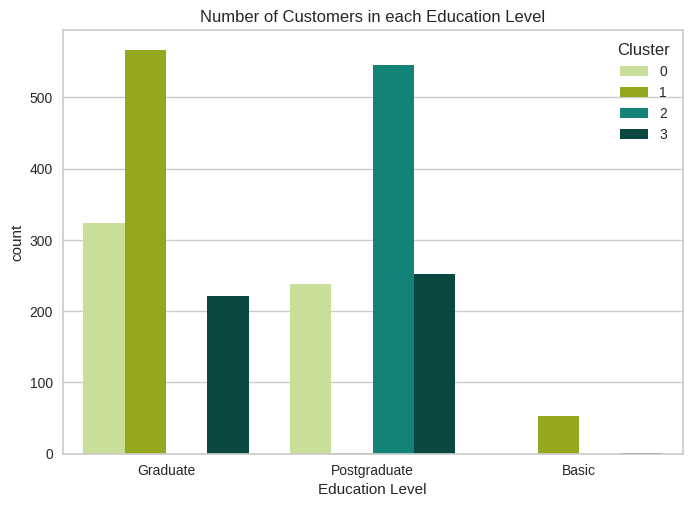

In [85]:
# Create a bar chart to show the number of customers in each Education Level and Cluster
plt.figure()
pl = sns.countplot(x=df['Education'], hue=df['Cluster'], palette=pal)
pl.set_title("Number of Customers in each Education Level")
pl.set_xlabel("Education Level")
plt.show()

*  Group 0 : minimum educational qualification is graduate.
*  Group 1 : consists of individuals with an educational background of no higher than a graduate.
*  Group 2 : consists entirely of customers with a postgraduate or higher.
*  Group 3 : minimum educational qualification is graduate.

---

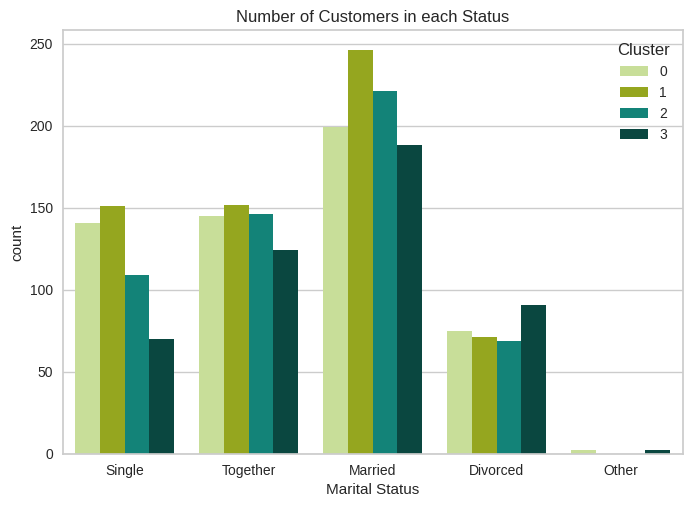

In [69]:
# Create a bar chart to show the number of customers in each Marital Status and Cluster
plt.figure()
pl = sns.countplot(x=df['Marital_Status'], hue=df['Cluster'], palette=pal)
pl.set_title("Number of Customers in each Status")
pl.set_xlabel("Marital Status")
plt.show()

Across all customer groups, number of marital statuses is relatively similar. There are `no significant differences` in the proportion of each marital status.


---



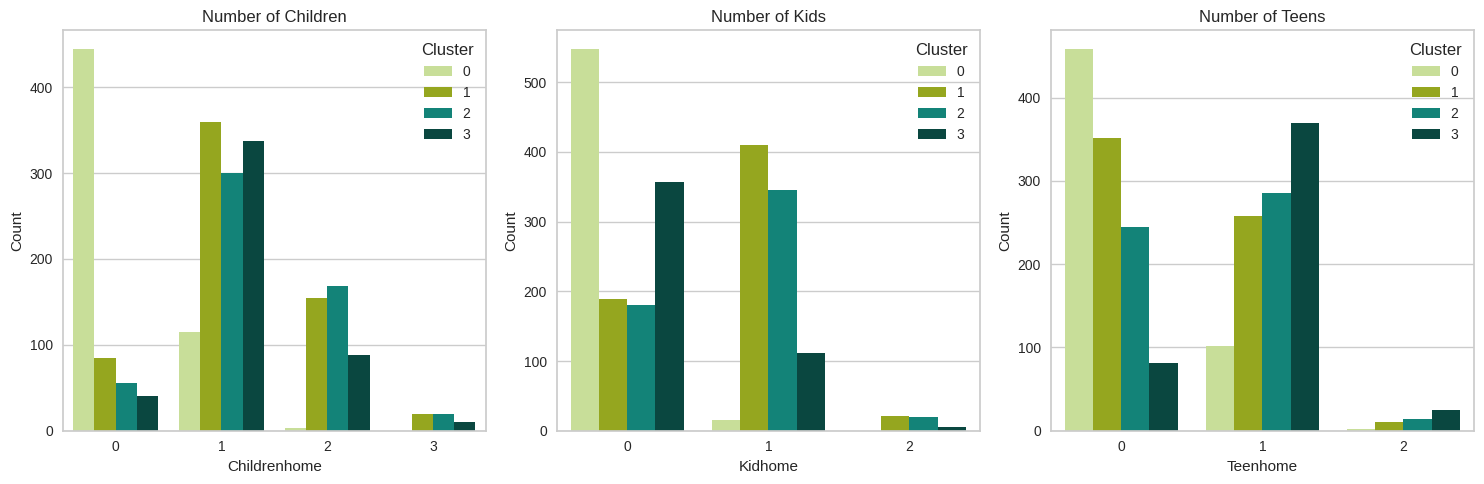

In [71]:
# Create a bar chart to show the number of Children, Kids, and Teens in each Cluster
Children = ['Childrenhome', 'Kidhome', 'Teenhome']
Title = ['Number of Children', 'Number of Kids', 'Number of Teens']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for ax, i, j in zip(axes, Children, Title):
    sns.countplot(x=df[i], hue=df['Cluster'], palette=pal, ax=ax)
    ax.set_title(j)
    ax.set_xlabel(i)
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

*  Group 0 : Households with at most two child, Majority of households in this segment have no children. If there is one child in the household, they are most likely teen.

*  Group 1 : Households with at most three child, Majority of households in this segment have one children. If there is one child in the household, they are more likely to be a kid rather than a teen.

*  Group 2 : Households with at most three child, Majority of households in this segment have one children. If there is one child in the household, they are as likely to be kid as they are to be teenagers.

*  Group 3 : Households with at most three child, Majority of households in this segment have one children. If there is one child in the household, they are more likely to be a teen rather than a kid.

---

<ipython-input-88-4ce8349cf269>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(y=df[Place[i]], x=df['Cluster'], palette=palettes, ax=ax)
<ipython-input-88-4ce8349cf269>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(y=df[Place[i]], x=df['Cluster'], palette=palettes, ax=ax)
<ipython-input-88-4ce8349cf269>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(y=df[Place[i]], x=df['Cluster'], palette=palettes, ax=ax)
<ipython-input-88-4ce8349cf269>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remo

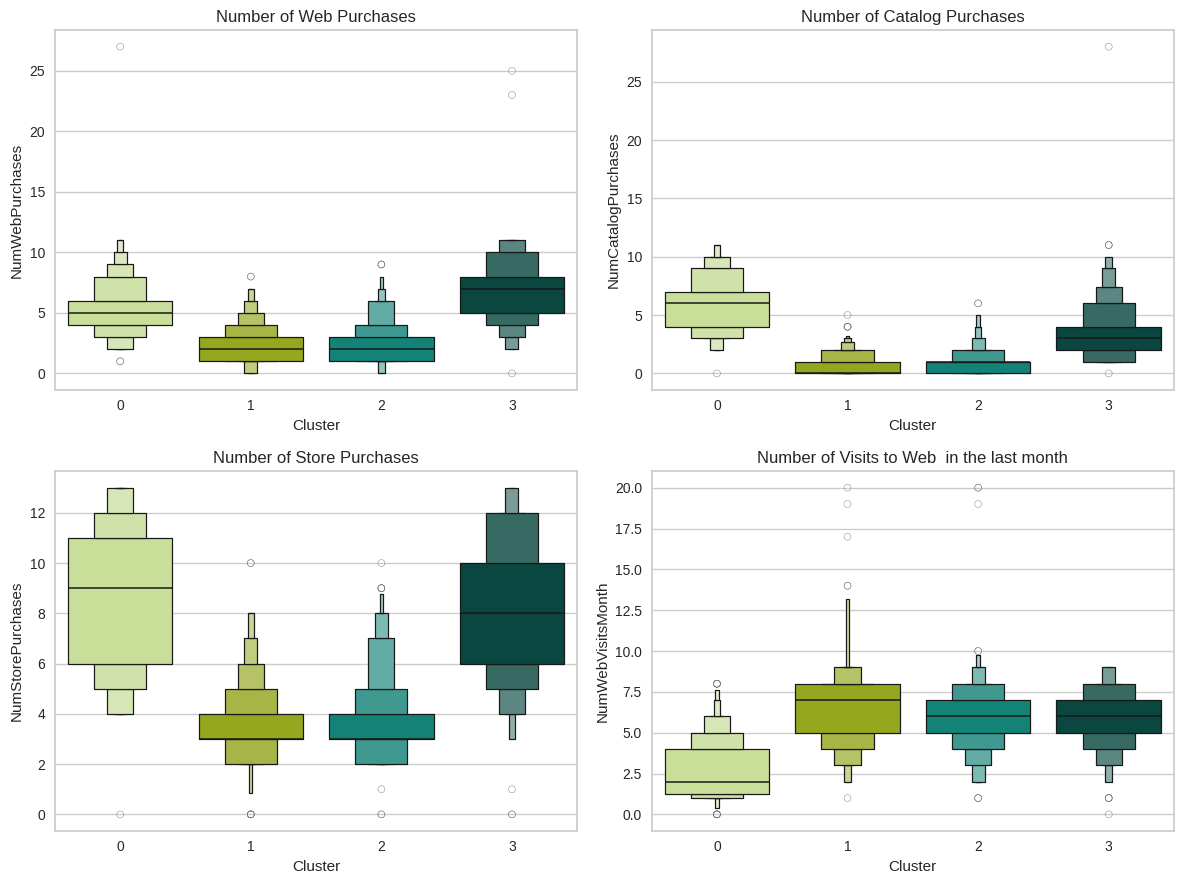

In [88]:
# Create a Boxen plot to visualize the distribution of Purchase Channels and Number of Visits to Web  in the last month across different clusters
Place = ['NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases', 'NumWebVisitsMonth']
Title = ['Number of Web Purchases', 'Number of Catalog Purchases', 'Number of Store Purchases', 'Number of Visits to Web  in the last month']
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
for i, ax in zip(range(len(Place)), axes.flatten()):
    sns.boxenplot(y=df[Place[i]], x=df['Cluster'], palette=palettes, ax=ax)
    ax.set_title(Title[i])
plt.tight_layout()
plt.show()

# 6. Conclusion

`Group 0 :`
*   Average income is approximately 75,000.-
*   Average spending is approximately 1,300.-
*   Minimum education level is a bachelor's degree
*   Families with up to 2 children, mostly childless. If present, likely a teen.
*   Prefers online purchases more than other groups.

`Group 1 :`
*   Average income is approximately 35,000.-
*   Average spending is approximately 70.-
*   Education level up to bachelor's degree
*   Families with up to 3 children, mostly one child, typically younger.
*   Visits the company website most frequently more than other groups.

`Group 2 : `
*   Average income is approximately 40,000.-
*   Average spending is approximately 80.-
*   All customers have a postgraduate degree or higher
*   Families with up to 3 children, mostly one child, equally likely to be young or teen.

`Group 3 : `
*   Average income is approximately 60,000.-
*   Average spending is approximately 800.-
*   Minimum education level is a bachelor's degree
*   Families with up to 3 children, mostly one child, typically a teenager.
*   Prefers catalog shopping more than other groups.

---